In [1]:
%matplotlib notebook

from DataSets import *
from MalardClient.MalardClient import MalardClient
from MalardClient.DataSet import DataSet
from MalardClient.BoundingBox import BoundingBox
#from RegressionRun import *
import matplotlib as mpl
import pandas as pd
import numpy.ma as ma
#from MalardClient import MalardHelpers
import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
import os
import json
import math
from pandas.io.json import json_normalize
from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
# read file
dfTimeseries = pd.read_json("timeseries_results/alaska-refDiff.json")
#elevation change
dfStats = gp.read_file("regression_results/alaska-weighted.gpkg")

dfTimeseries

,gridCell.minX,gridCell.minY,gridCell.size,statistics.ADwithTDX_filtered,statistics.DebrisMaskArea,statistics.GlacierMaskArea,statistics.afterGlacierMask,statistics.meanElevationDifference,statistics.pointsOnDataSetValue0,statistics.pointsOnDataSetValue0Ratio,...,statistics.result_refDifference_2015,statistics.result_refDifference_2016,statistics.result_refDifference_2017,statistics.result_refDifference_2018,statistics.result_refDifference_2019,statistics.result_total,timeseries.dates,timeseries.averages,timeseries.medians,timeseries.change
0,-3900000,-600000,100000,525156,0.953197,25.316884,102,-18.988451,6.0,5.882353,...,-19.575431,-6.194887,-50.917235,14.618241,0.000000,102,"[1288569600000, 1296518400000, 1304208000000, ...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non..."
1,-3900000,-500000,100000,224707,2.100895,56.170261,991,-9.611851,117.0,11.806256,...,-16.557266,-6.622780,-24.566163,-26.558144,0.000000,991,"[1288569600000, 1296518400000, 1304208000000, ...","[1.1180992392, None, None, None, 6.258053421, ...","[0.21332936800000002, None, None, None, 5.0834...","[0.0, None, None, None, 5.1399541818, 6.164488..."
10,-3800000,-100000,100000,93131,0.863271,4.842713,298,7.296313,NaN,NaN,...,0.000000,14.855902,4.242323,-4.944204,4.316501,298,"[1288569600000, 1296518400000, 1304208000000, ...","[None, None, None, None, 11.851204958, None, N...","[None, None, None, None, 13.813597355, None, N...","[None, None, None, None, None, None, None, Non..."
100,-2900000,900000,100000,4446471,15.939919,175.735366,14883,277.228135,228.0,1.531949,...,294.255160,317.430475,275.536124,112.506272,301.881829,14883,"[1288569600000, 1296518400000, 1304208000000, ...","[None, 37.5125530782, 83.206224936, 7.47505655...","[None, 41.2898477583, 95.3101485705, 7.7192833...","[None, None, None, None, None, None, None, Non..."
101,-2800000,-300000,100000,68379,0.734354,11.074497,170,-13.100389,124.0,72.941176,...,-35.517732,0.000000,-10.969739,-19.850462,0.000000,170,"[1288569600000, 1296518400000, 1304208000000, ...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non..."
102,-2800000,-200000,100000,58557,0.568200,8.498691,368,-13.865357,28.0,7.608696,...,-13.308209,-21.142302,-22.358756,-21.532430,0.000000,368,"[1288569600000, 1296518400000, 1304208000000, ...","[None, None, -11.0880092982, -6.4765247335, No...","[None, None, -14.8457110621, -5.8714060143, No...","[None, None, None, None, None, None, None, Non..."
103,-2800000,-100000,100000,24903,0.095388,0.894702,10,3.975512,NaN,NaN,...,-16.287892,0.000000,0.000000,24.238916,0.000000,10,"[1288569600000, 1296518400000, 1304208000000, ...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non..."
11,-3700000,-600000,100000,241299,0.796679,5.393263,335,-51.118525,24.0,7.164179,...,-8.494866,-48.643107,-51.910003,-39.759436,0.000000,335,"[1288569600000, 1296518400000, 1304208000000, ...","[-27.266695885, -47.5024665988, None, -31.0307...","[-27.266695885, -47.4022172264, None, -30.9716...","[0.0, -20.2357707137, None, -3.7640525144, -27..."
12,-3700000,-500000,100000,310409,1.953797,55.968081,6938,-2.010713,1633.0,23.537042,...,-1.839226,-4.658152,-5.565011,-11.534662,-16.875295,6938,"[1288569600000, 1296518400000, 1304208000000, ...","[8.8979178815, 4.4745150560999996, -8.59315845...","[6.9139785708, 3.9783422908, -3.4131161885, -3...","[0.0, -4.4234028254, -17.4910763348, -21.35138..."
13,-3700000,-400000,100000,237838,25.354026,330.081677,58933,-1.523023,3064.0,5.199124,...,-3.874649,-2.288501,-2.392352,-4.212330,-2.865604,58933,"[1288569600000, 1296518400000, 1304208000000, ...","[1.4918201542, 4.6796342047, -6.6496014362, -3...","[1.7388456276, 4.95369946, 2.2888468886, -0.44...","[0.0, 3.187814050

In [3]:
for idx, line in dfTimeseries.iloc[:2].iterrows():
    dates=[datetime.fromtimestamp(x/1000) for x in line['timeseries.dates']]

In [4]:
client = MalardClient()
parentDs = "mtngla"
inputDataSet = "ReadyDataAlaska2"
region = "alaska"
dataSet = DataSet(parentDs=parentDs, dataSet=inputDataSet, region=region)
projection = client.getProjection(dataSet).proj4

bbx = client.boundingBox(dataSet)
minT = bbx.minT
maxT = bbx.maxT

filters = [{'column':'power','op':'gt','threshold':10000},{'column':'coh','op':'gt','threshold':0.6}, \
                    {'column':'demDiff','op':'lt','threshold':100}, {'column':'demDiffMad','op':'lt','threshold':10}, \
                    {'column':'demDiff','op':'gt','threshold':-100}, {'column':'demDiffMad','op':'gt','threshold':-10}, \
                    {'column':'refDifference','op':'gt','threshold':-150}, {'column':'refDifference','op':'lt','threshold':150}]

interval = 3
startdate = min(dates)
enddate = max(dates)

In [5]:
def getData(minX, maxX, minY, maxY):
    bbx_in = BoundingBox(minX, maxX, minY, maxY, minT, maxT)
    result = client.executeQuery(dataSet, bbx_in, projections=[], filters=filters)
    data = PointDataSet(result.resultFileName, projection)
    dateobjects = []
    for i, row in data.data.iterrows():
        date = datetime.utcfromtimestamp(data.data.time[i])
        dateobjects.append(date)
    data.data['dateobject'] = dateobjects

    use_date = startdate
    while use_date <= enddate:
        data.data.loc[(data.data.dateobject >= use_date) & (data.data.dateobject <(use_date+relativedelta(months=+interval))), 'date_class'] = use_date
        use_date = use_date+relativedelta(months=+interval)
    return data.data


In [10]:
# plot preparation:

dfStats.loc[(dfStats['statistics.GlacierMaskArea']<10.0), 'statistics.GlacierMaskArea.pointsize'] = 5
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=10.0) & (dfStats['statistics.GlacierMaskArea']<100.0), 'statistics.GlacierMaskArea.pointsize'] = 20
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=100.0) & (dfStats['statistics.GlacierMaskArea']<500.0), 'statistics.GlacierMaskArea.pointsize'] = 50
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=500.0) & (dfStats['statistics.GlacierMaskArea']<1000.0), 'statistics.GlacierMaskArea.pointsize'] = 80
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=1000.0) & (dfStats['statistics.GlacierMaskArea']<2000.0), 'statistics.GlacierMaskArea.pointsize'] = 125
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>2000.0), 'statistics.GlacierMaskArea.pointsize'] = 170

coastline = gp.read_file('/data/puma1/scratch/mtngla/background-shapefiles/alaska/coastline.shp')

colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # R -> W -> B
n_bin = 98  # Discretizes the interpolation into bins
# Create the colormap
cm_ = LinearSegmentedColormap.from_list('my_list', colors, N=n_bin)
cm = LinearSegmentedColormap.from_list('extremes',list(map(cm_,range(100))), N=100)
vmin=-2
vmax=2
markersize = dfStats['statistics.GlacierMaskArea.pointsize']
labels = ["<10", "10-100", "100-500", "500-1000", "1000-2000", ">2000"]
sizes = [5, 20, 50, 80, 125, 170]



In [13]:
def plotDash(row, regression, timeseries, reg_plot, details=False, detail=None, detailtype=None):
    gridcellMinX = dfTimeseries.loc[dfTimeseries.index[row], 'gridCell.minX']
    gridcellMinY = dfTimeseries.loc[dfTimeseries.index[row], 'gridCell.minY']
    size = dfTimeseries.loc[dfTimeseries.index[row], 'gridCell.size']
    regression_line = dfStats[(dfStats['gridCell.minX']==gridcellMinX)&(dfStats['gridCell.minY']==gridcellMinY)]
    print('Glacier mask area: %.3f km' % (dfTimeseries.iloc[row]['statistics.GlacierMaskArea']))
    print('Total points: stats={}, regression={}, w_power={}, w_power_masked={}'.format(dfTimeseries.iloc[row]['statistics.result_total'], regression_line['regression.count'].values[0], regression_line['regression.w_power.count'].values[0], regression_line['regression.w_power.count_masked'].values[0]))
    print('Points per km2: %s' % (dfTimeseries.iloc[row]['statistics.result_total']/dfTimeseries.iloc[row]['statistics.GlacierMaskArea']))
    pdratio = dfTimeseries.iloc[row]['statistics.pointsWithinDebrisMask']/dfTimeseries.iloc[row]['statistics.result_total']*100
    print('Points on debris: %s  \t\t\t Points on debris ratio: %.2f percent' % (dfTimeseries.iloc[row]['statistics.pointsWithinDebrisMask'], pdratio))
    print('Points on TDX: %.2f percent' % (dfTimeseries.iloc[row]['statistics.pointsOnDataSetValue2Ratio']))
    print('Points on AD: %.2f percent' % (dfTimeseries.iloc[row]['statistics.pointsOnDataSetValue1Ratio']))
    print('Points on Interp: %.2f percent' % (dfTimeseries.iloc[row]['statistics.pointsOnDataSetValue0Ratio']))
    #print('RSquared: %.2f' % (regression_line['regression.rsquared']))
    print('Elevation change: %.3f m/y \t Robust: %.3f m/y \t w_power: %.3f m/y \t w_coh: %.3f m/y' % (regression_line['regression.c.year'], regression_line['regression.robust.c.year'], regression_line['regression.w_power.c.year'], regression_line['regression.w_coh.c.year']))
    print('Standard error: %.3f m \t Robust: %.3f m \t w_power: %.3f m \t w_coh: %.3f m ' % (regression_line['regression.c.se.year'], regression_line['regression.robust.c.se.year'], regression_line['regression.w_power.c.se.year'], regression_line['regression.w_coh.c.se.year']))
    print('Regression constant: %.3f m \t\t Robust regression constant: %.3f m' % (regression_line['regression.const'],regression_line['regression.robust.const']))

    dates=[datetime.fromtimestamp(x/1000) for x in dfTimeseries.iloc[row]['timeseries.dates']]
    
    if not details:
        fig, ax = plt.subplots(1,2,figsize=(9.8,5.5))
    else:
        fig, ax = plt.subplots(3,1,figsize=(8.8,13.5))
    # 1 plot time series
    ax[1].plot(dates , dfTimeseries.iloc[row]['timeseries.{}'.format(timeseries)], linewidth=0.7, marker='^', markersize=2)
    

    # calculate regression prediction
    colors=['red', 'orange', 'yellow', 'green']
    for i,reg in enumerate(reg_plot):
        reg=reg+'.'
        minTime = datetime.timestamp(min(dates))
        maxTime = datetime.timestamp(max(dates))
        minTimeValue = regression_line['regression.{}c'.format(reg)].values*minTime+regression_line['regression.{}const'.format(reg)].values
        maxTimeValue = regression_line['regression.{}c'.format(reg)].values*maxTime+regression_line['regression.{}const'.format(reg)].values
        predict_v = [minTimeValue[0],maxTimeValue[0]]
    
        # add regression line
        ax[1].plot([min(dates), max(dates)], predict_v, color=colors[i], linewidth=0.5, label=reg)

    
    # more things are plotted
    if details:
        size=int(regression_line['gridCell.size'].values[0])
        minX=int(regression_line['gridCell.minX'].values[0])
        maxX=minX+size
        minY=int(regression_line['gridCell.minY'].values[0])
        maxY=minY+size
        dta = getData(minX=minX, maxX=maxX, minY=minY, maxY=maxY)
        counts=dta.groupby('date_class').index.count()
        keys = list(dta.groupby('date_class').groups.keys())
        ax_left = ax[1].twinx()
        ax_left.scatter(keys, counts, color='grey', label='counts', marker='o', s=5)
        pos = ax[2].get_position() # get the original position 
        addXAx=(pos.x1-pos.x0)/7
        #addYAx=(pos.y1-pos.y0)/6
        incX=0
        incY=0
        for i,date in enumerate(list(dta.groupby('date_class').groups.keys())):
            x=pos.x0+incX
            y=0.3+incY
            incX=incX+addXAx
            s=i+1
            if s%8==0:
                incX= 0
                incY=incY-0.06
            a = plt.axes([x, y, .07, .03], facecolor='lightgrey')
            filt=dta[dta['date_class']==date]
            if detailtype=='hist':
                filt[detail].hist()
            elif detailtype=='pie':
                filt[detail].plot.pie()
            else:
                filt[detail].plot()
            plt.xticks(fontsize = 6)
            plt.yticks(fontsize = 6)
            plt.title(i, fontsize = 7, pad=0.1)
    
        ax[2].get_xaxis().set_visible(False)
        ax[2].get_yaxis().set_visible(False)
        ax[2].axis('off')
        valsNotNone = [x for x in dfTimeseries.iloc[row]['timeseries.{}'.format(timeseries)] if x is not None]
        for idx, d in enumerate(list(dta.groupby('date_class').groups.keys())):
            ax[1].annotate(idx, (d, valsNotNone[idx]), fontsize=8)
            #dfTimeseries.iloc[row]['timeseries.{}'.format(timeseries)][idx]
    
    # finish ax1
    ax[1].set_xlim(min(dates), max(dates))
    ax[1].set_xlabel('Years')
    ax[1].set_ylabel('Elevation change ({}) [m]'.format(timeseries))
    ax[1].legend()
    
    # 2 plot map
    coastline.plot(color='blue', edgecolor=None, linewidth=0.2, ax=ax[0])


    regression=regression+'.'
    dfStats.plot(column='regression.{}c.year'.format(regression), markersize=markersize, vmin=vmin, \
                         vmax=vmax, cmap=cm, ax=ax[0])
    markers=[]
    for s in sizes:
        markers.append(plt.scatter([],[], s=s, label=s, color='white', edgecolor='black', linewidth=0.5))

    ax[0].legend(handles=markers)
    leg = ax[0].legend(markers, labels, ncol=1, frameon=True, fontsize=7,handlelength=1, loc = 0, borderpad = 1.3,\
    handletextpad=1, title='Glacier area [km2]', scatterpoints = 1, labelspacing=1.5)

    #ax[0].set_ylim(-2000000, 1000000)
    #ax[0].set_xlim(-900000, 1700000)
    # add number of gridcell
    for i, txt in enumerate(dfTimeseries['statistics.result_total']):
        ax[0].annotate(i, (dfTimeseries.loc[dfTimeseries.index[i], 'gridCell.minX']+ \
                               (size/2)+10000, dfTimeseries.loc[dfTimeseries.index[i], 'gridCell.minY']+\
                               (size/2)+10000), fontsize=5)
    # add X
    ax[0].annotate('x', (gridcellMinX+(size/2)-30000, gridcellMinY+(size/2)-30000), fontsize=12)
    ax[0].set_xlim(-5000000, -2700000)
    ax[0].set_ylim(-900000, 1700000)
    
    ax[1].set_xlim(min(dates), max(dates))
    
    

    if not details:
        bar=fig.colorbar(ax=ax[1], orientation='horizontal',  pad=0.35, mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cm))
        bar.set_label('Elevation change per year [m]')
        plt.tight_layout()
        ax[1].yaxis.tick_right()
        ax[1].yaxis.set_label_position("right")
        
    

Glacier mask area: 541.131 km
Total points: stats=23895, regression=19368.0, w_power=18983.0, w_power_masked=385.0
Points per km2: 44.15747803684581
Points on debris: 916  			 Points on debris ratio: 3.83 percent
Points on TDX: 27.02 percent
Points on AD: 72.43 percent
Points on Interp: 0.54 percent
Elevation change: -2.573 m/y 	 Robust: -1.271 m/y 	 w_power: -2.776 m/y 	 w_coh: -2.092 m/y
Standard error: 0.109 m 	 Robust: 0.077 m 	 w_power: 0.098 m 	 w_coh: 0.097 m 
Regression constant: 121.644 m 		 Robust regression constant: 59.055 m


<IPython.core.display.Javascript object>


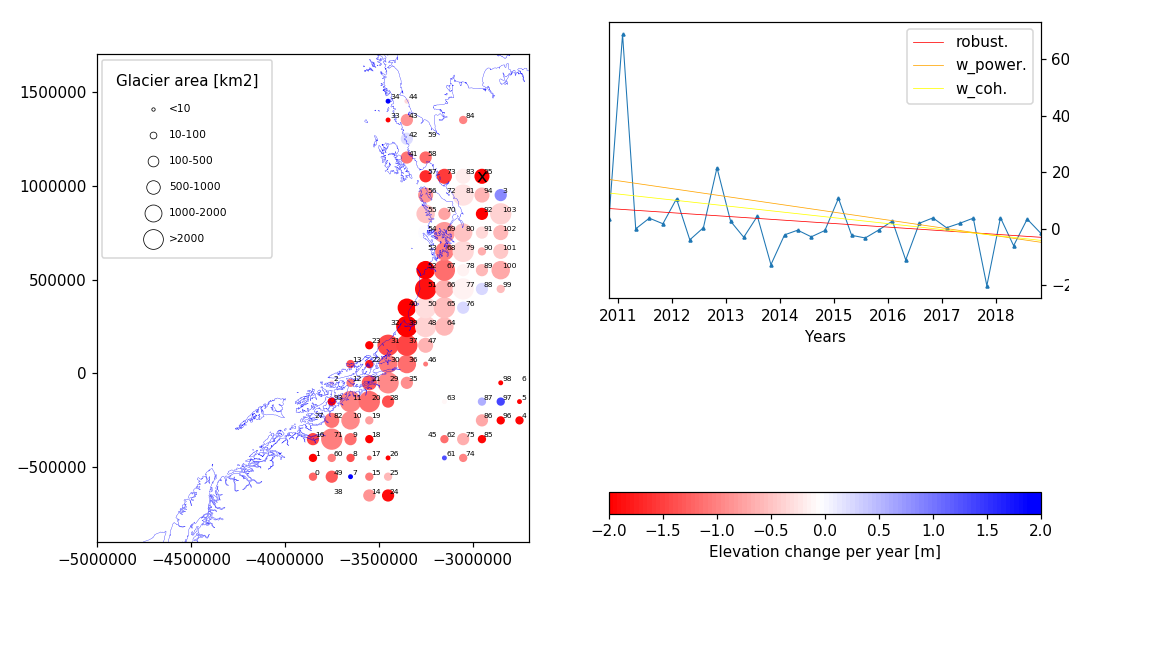

In [14]:
%matplotlib notebook
# change this
row=95
reg_map='w_power'
reg_plot=['robust','w_power','w_coh']
timeseries='medians'
plotDash(row, reg_map, timeseries, reg_plot)

Glacier mask area: 2635.782 km
Total points: stats=243208, regression=232853.0, w_power=225059.0, w_power_masked=7794.0
Points per km2: 92.27165592907525
Points on debris: 10052  			 Points on debris ratio: 4.13 percent
Points on TDX: 52.88 percent
Points on AD: 45.09 percent
Points on Interp: 2.03 percent
Elevation change: -0.438 m/y 	 Robust: -0.209 m/y 	 w_power: -0.397 m/y 	 w_coh: -0.332 m/y
Standard error: 0.026 m 	 Robust: 0.014 m 	 w_power: 0.019 m 	 w_coh: 0.018 m 
Regression constant: 23.878 m 		 Robust regression constant: 11.218 m


<IPython.core.display.Javascript object>


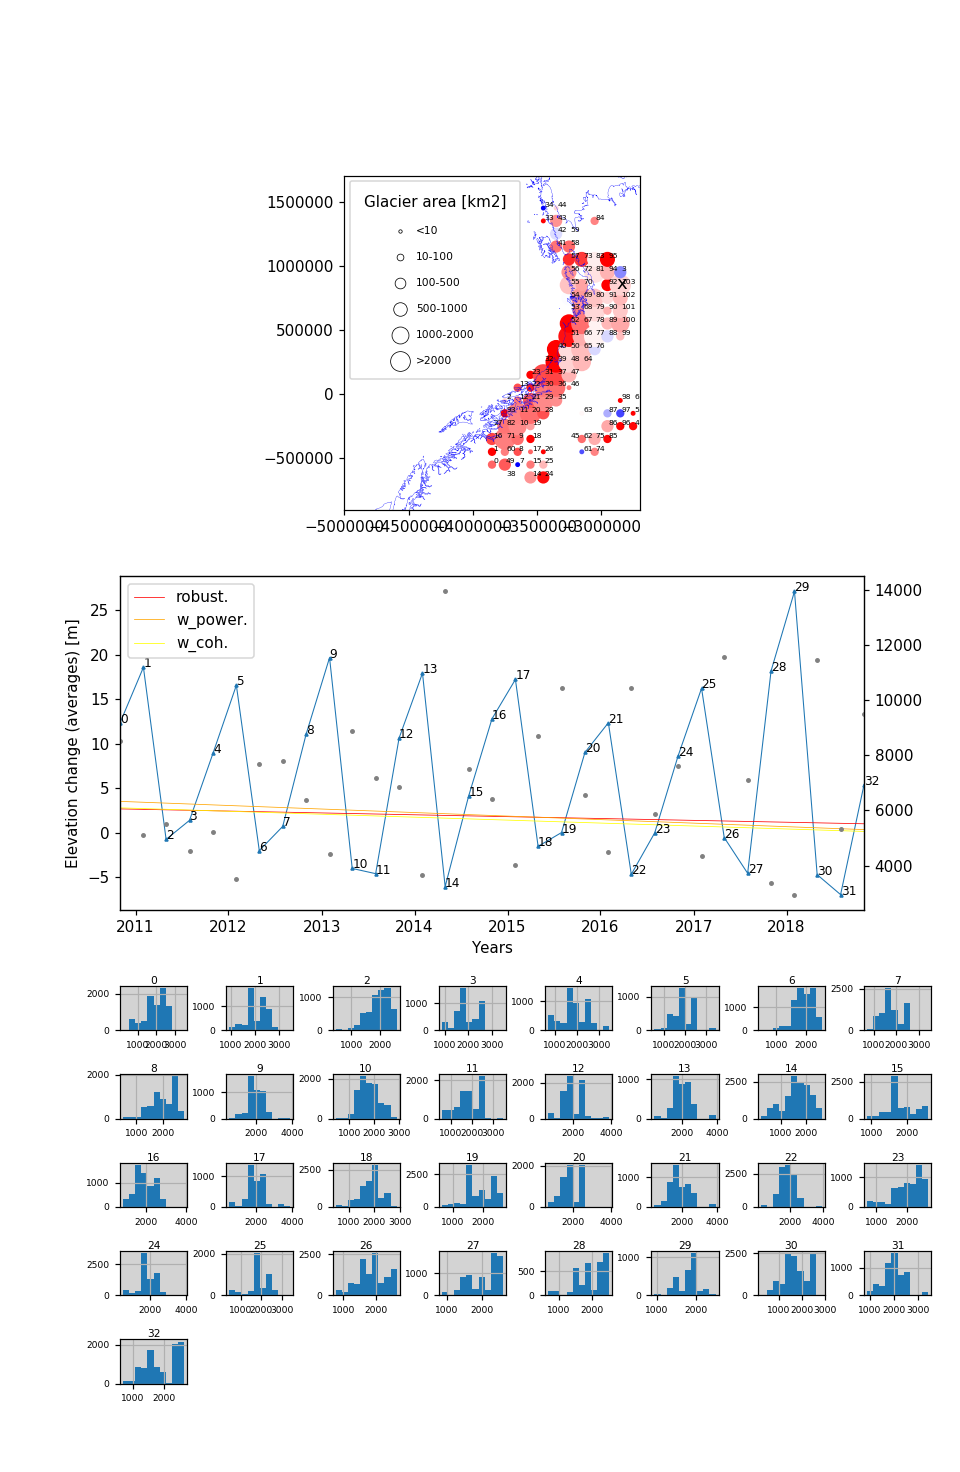

In [27]:
%matplotlib notebook
# change this
row=103
reg_map='w_power'
reg_plot=['robust','w_power','w_coh']
timeseries='averages'
plotDash(row, reg_map, timeseries, reg_plot, details=True, detail='elev', detailtype='hist')

<IPython.core.display.Javascript object>


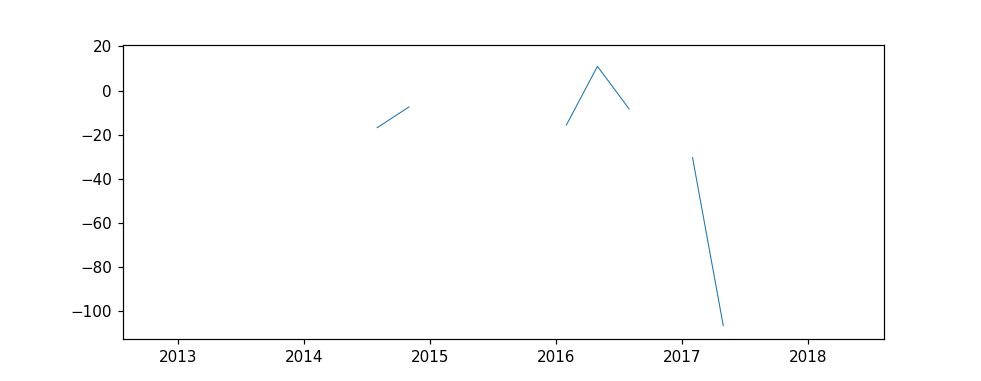

In [23]:
%matplotlib notebook
plt.figure(figsize=(9,3.5))

row=dfTimeseries.loc[(dfStats['gridCell.minX']==-3900000) & (dfStats['gridCell.minY']==-600000)]
 
dates=[datetime.fromtimestamp(x/1000) for x in row.iloc[0]['timeseries.dates']]
plt.plot(dates , row.iloc[0]['timeseries.averages'], linewidth=0.7)

In [17]:
def plotTS(row):
    dates=[datetime.fromtimestamp(x/1000) for x in dfTimeseries.iloc[row]['timeseries.dates']]

    fig, ax = plt.subplots(figsize=(8,5))
    # time series
    ax.plot(dates , dfTimeseries.iloc[row]['timeseries.averages'], linewidth=0.7)

    ax.set_xlim(min(dates), max(dates))
    ax.set_xlabel('Year')
    ax.set_ylabel('Mean elevation difference to reference DEM [m]')
    #ax[1].yaxis.tick_right()
    #ax[1].yaxis.set_label_position("right")
    plt.title('3-Month time series')

    plt.tight_layout()
    

<IPython.core.display.Javascript object>


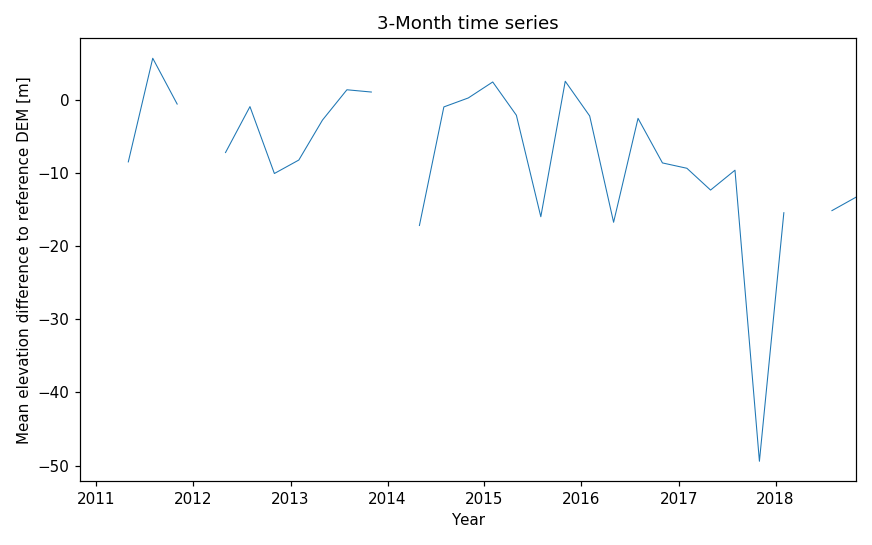

In [18]:
plotTS(96)

In [21]:
def plotMap(row):
    dates=[datetime.fromtimestamp(x/1000) for x in dfTimeseries.iloc[row]['timeseries.dates']]

    fig, ax = plt.subplots(figsize=(7,7))

    coastline.plot(color='blue', edgecolor=None, linewidth=0.2, ax=ax)

    dfStats.plot(column='regression.robust.c.year', markersize=markersize, vmin=vmin, \
                         vmax=vmax, cmap=cm, ax=ax, edgecolor='grey', linewidth=0.2)
    markers=[]
    for s in sizes:
        markers.append(plt.scatter([],[], s=s, label=s, color='white', edgecolor='black', linewidth=0.5))

    bar=fig.colorbar(ax=ax, orientation='vertical', pad=0.05, mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cm))
    bar.set_label('Elevation change [m/yr]')

    #ax.legend(handles=markers)
    #leg = ax.legend(markers, labels, ncol=1, frameon=True, fontsize=7,handlelength=1, loc = 0, borderpad = 1.3,\
    #handletextpad=1, title='Glacier area [km2]', scatterpoints = 1, labelspacing=1.5)
    #plt.title('DhDt Himalayas')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.xticks([])
    plt.yticks([])
    ax.set_xlim(-4700000, -2400000)
    ax.set_ylim(-920000, 1800000)

<IPython.core.display.Javascript object>


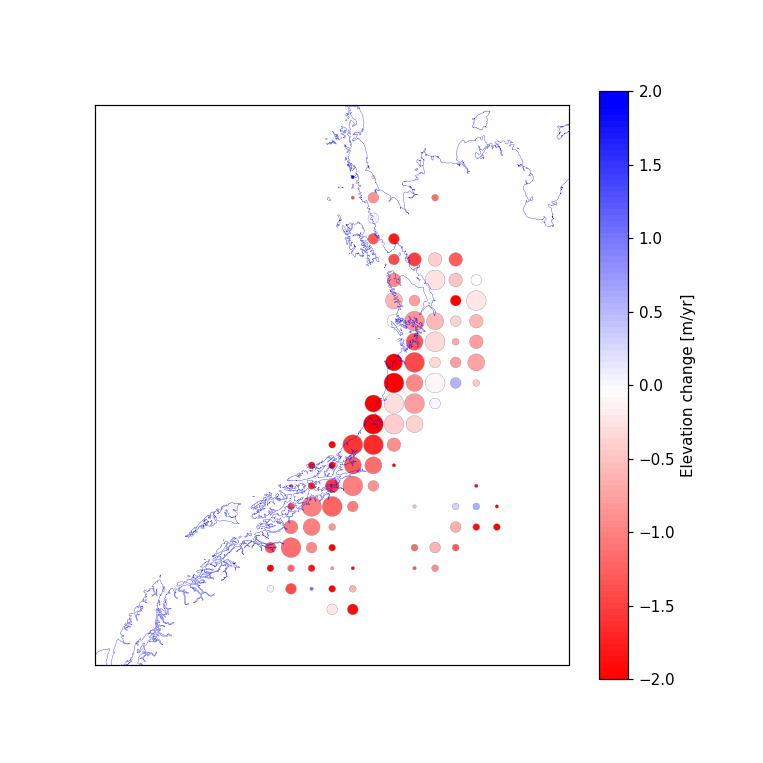

In [22]:
plotMap(0)